In [1]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler

from tensorflow.keras.models import Model

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, concatenate, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import os
import cv2

## 1: Cargar el DataFrame

In [2]:
# Ruta al archivo CSV
archivo_csv = 'df_BUENO_ID.csv'  
df_bueno = pd.read_csv(archivo_csv)


In [3]:
# Mostrar las primeras filas para confirmar que se cargó correctamente
df_bueno.head()

,Unnamed: 0,id_image,Price,Beds,Baths,Square Feet,Street,City,COUNTY,average_listing_price
0,0,2200 Sacramento St APT 206,1720000.0,2,2,969.0,2200 Sacramento St APT 206,SAN FRANCISCO,SAN FRANCISCO,1939987.0
1,1,114 10th Ave,1850000.0,3,2,2181.0,114 10th Ave,SAN FRANCISCO,SAN FRANCISCO,1939987.0
2,2,1982 44th Ave,1450000.0,3,2,1150.0,1982 44th Ave,SAN FRANCISCO,SAN FRANCISCO,1939987.0
3,3,2731 41st Ave,1310000.0,2,1,1012.0,2731 41st Ave,SAN FRANCISCO,SAN FRANCISCO,1939987.0
4,4,216 Dorland St,1360000.0,2,2,1132.0,216 Dorland St,SAN FRANCISCO,SAN FRANCISCO,1939987.0


In [4]:
df_bueno.tail()

,Unnamed: 0,id_image,Price,Beds,Baths,Square Feet,Street,City,COUNTY,average_listing_price
316,316,2232 Daladier Dr,1680000.0,4,3,2948.0,2232 Daladier Dr,RANCHO PALOS VERDES,LOS ANGELES,2606021.0
317,317,27989 Beechgate Dr,1550000.0,4,3,2390.0,27989 Beechgate Dr,RANCHO PALOS VERDES,LOS ANGELES,2606021.0
318,318,13218 La Jolla Cir UNIT C,675000.0,3,2,1271.0,13218 La Jolla Cir UNIT C,LA MIRADA,LOS ANGELES,2606021.0
319,319,14348 Flomar Dr,745000.0,2,2,1479.0,14348 Flomar Dr,WHITTIER,LOS ANGELES,2606021.0
320,320,816 Reed Dr,900000.0,3,2,1610.0,816 Reed Dr,CLAREMONT,LOS ANGELES,2606021.0


## EDA

### Análisis de Datos Tabulares

In [5]:
df_bueno.shape

(321, 10)

In [6]:
df_bueno.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321 entries, 0 to 320
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             321 non-null    int64  
 1   id_image               321 non-null    object 
 2   Price                  321 non-null    float64
 3   Beds                   321 non-null    int64  
 4   Baths                  321 non-null    int64  
 5   Square Feet            321 non-null    float64
 6   Street                 321 non-null    object 
 7   City                   321 non-null    object 
 8   COUNTY                 321 non-null    object 
 9   average_listing_price  321 non-null    float64
dtypes: float64(3), int64(3), object(4)
memory usage: 25.2+ KB


La columna Price y average_listing_price están en formato object, lo cual quiere decir que se están tratando como cadenas de texto en lugar de números.

### Primero, vamos a asegurarnos de que las comas (si las hay) se eliminen, y los puntos decimales se manejen correctamente

In [7]:
# Para 'price'
df_bueno['Price'] = df_bueno['Price'].replace({'\$': '', ',': '', '\.': ''}, regex=True).astype(float)

In [8]:
# Para 'median_listing_price'
df_bueno['average_listing_price'] = df_bueno['average_listing_price'].replace({'\$': '', ',': '', '\.': ''}, regex=True).astype(float)

In [9]:
# A continuación, convertimos las columnas a numérico utilizando pd.to_numeric() por si acaso hay valores que no se han limpiado correctamente
df_bueno['Price'] = pd.to_numeric(df_bueno['Price'], errors='coerce')
df_bueno['average_listing_price'] = pd.to_numeric(df_bueno['average_listing_price'], errors='coerce')

Comprobamos

In [10]:
df_bueno.dtypes

Unnamed: 0                 int64
id_image                  object
Price                    float64
Beds                       int64
Baths                      int64
Square Feet              float64
Street                    object
City                      object
COUNTY                    object
average_listing_price    float64
dtype: object

Revisamos si hay valores NaN en las columnas Price y median_listing_price, después de la conversión-

In [11]:
df_bueno.isnull().sum()

Unnamed: 0               0
id_image                 0
Price                    0
Beds                     0
Baths                    0
Square Feet              0
Street                   0
City                     0
COUNTY                   0
average_listing_price    0
dtype: int64

Eliminamos la columna Unnamed: 0, porque no es relevante para el análisis.

In [12]:
df_bueno.drop(columns=['Unnamed: 0'], inplace=True)

In [13]:
df_bueno

,id_image,Price,Beds,Baths,Square Feet,Street,City,COUNTY,average_listing_price
0,2200 Sacramento St APT 206,1720000.0,2,2,969.0,2200 Sacramento St APT 206,SAN FRANCISCO,SAN FRANCISCO,1939987.0
1,114 10th Ave,1850000.0,3,2,2181.0,114 10th Ave,SAN FRANCISCO,SAN FRANCISCO,1939987.0
2,1982 44th Ave,1450000.0,3,2,1150.0,1982 44th Ave,SAN FRANCISCO,SAN FRANCISCO,1939987.0
3,2731 41st Ave,1310000.0,2,1,1012.0,2731 41st Ave,SAN FRANCISCO,SAN FRANCISCO,1939987.0
4,216 Dorland St,1360000.0,2,2,1132.0,216 Dorland St,SAN FRANCISCO,SAN FRANCISCO,1939987.0
...,...,...,...,...,...,...,...,...,...
316,2232 Daladier Dr,1680000.0,4,3,2948.0,2232 Daladier Dr,RANCHO PALOS VERDES,LOS ANGELES,2606021.0
317,27989 Beechgate Dr,1550000.0,4,3,2390.0,27989 Beechgate Dr,RANCHO PALOS VERDES,LOS ANGELES,2606021.0
318,13218 La Jolla Cir UNIT C,675000.0,3,2,1271.0,13218 La Jolla Cir UNIT C,LA MIRADA,LOS ANGELES,2606021.0
319,14348 Flomar Dr,745000.0,2,2,1479.0,14348 Flomar Dr,WHITTIER,LOS ANGELES,2606021.0


### Descripción estádistica

In [14]:
df_bueno.describe()

,Price,Beds,Baths,Square Feet,average_listing_price
count,3.210000e+02,321.000000,321.000000,321.000000,3.210000e+02
mean,1.053946e+06,3.190031,2.445483,1829.464174,1.861715e+06
std,7.270849e+05,0.960807,0.882638,774.998693,9.304806e+05
min,4.100000e+03,1.000000,1.000000,572.000000,4.923580e+05
25%,5.800000e+05,3.000000,2.000000,1277.000000,9.433480e+05
50%,8.200000e+05,3.000000,2.000000,1689.000000,1.834937e+06
75%,1.400000e+06,4.000000,3.000000,2103.000000,2.606021e+06
max,4.950000e+06,8.000000,6.000000,5173.000000,5.009413e+06


Vamos a identificar porque en la columna de Price apaarecen valores tan extremos.

## 1. Identificar los valores extremos 

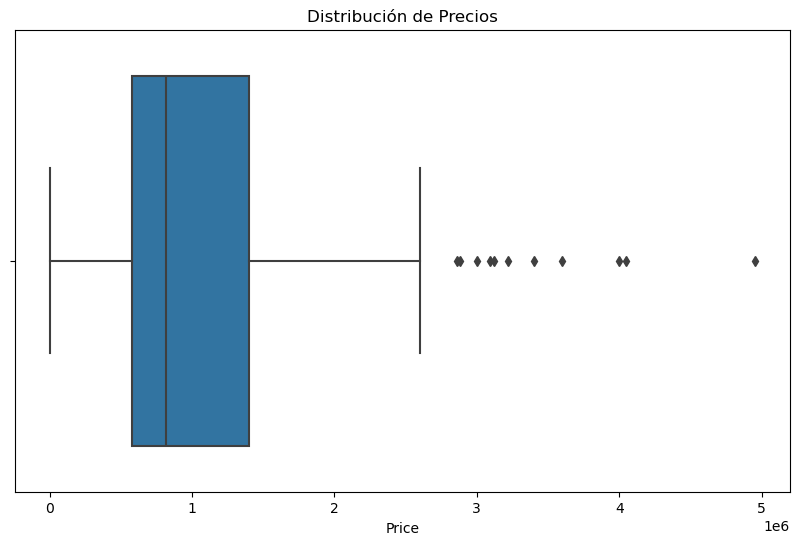

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_bueno['Price'])
plt.title('Distribución de Precios')
plt.show()

Si entramos en detalle, utilizando el rango intercuartílico (IQR)

In [16]:
Q1 = df_bueno['Price'].quantile(0.25)
Q3 = df_bueno['Price'].quantile(0.75)
IQR = Q3 - Q1
umbral_inferior = Q1 - 1.5 * IQR
umbral_superior = Q3 + 1.5 * IQR

outliers = df_bueno[(df_bueno['Price'] < umbral_inferior) | (df_bueno['Price'] > umbral_superior)]
print(f"Se encontraron {len(outliers)} outliers en la columna 'Price'.")


Se encontraron 11 outliers en la columna 'Price'.


Vamos a identificar que filas son:

In [17]:
outliers

,id_image,Price,Beds,Baths,Square Feet,Street,City,COUNTY,average_listing_price
24,1306 Rainbow Dr,3090000.0,4,3,2670.0,1306 Rainbow Dr,SAN MATEO,SAN MATEO,3157364.0
47,1740 La Coronilla Dr,2880000.0,3,2,1774.0,1740 La Coronilla Dr,SANTA BARBARA,SANTA BARBARA,5009413.0
211,692 Vanderbilt Dr,2860000.0,4,3,1990.0,692 Vanderbilt Dr,SUNNYVALE,SANTA CLARA,2102520.0
239,4133 Farmdale Ave,3400000.0,5,6,4012.0,4133 Farmdale Ave,LOS ANGELES,LOS ANGELES,2606021.0
264,917 Pacific Ave,4050000.0,5,4,4200.0,917 Pacific Ave,MANHATTAN BEACH,LOS ANGELES,2606021.0
269,15215 Friends St,3600000.0,3,3,2020.0,15215 Friends St,LOS ANGELES,LOS ANGELES,2606021.0
270,1172 Lachman Ln,4950000.0,4,4,3203.0,1172 Lachman Ln,LOS ANGELES,LOS ANGELES,2606021.0
271,1804 Manzanita Park Ave,3000000.0,5,4,2700.0,1804 Manzanita Park Ave,MALIBU,LOS ANGELES,2606021.0
286,7048 Macapa Dr,4000000.0,3,3,2949.0,7048 Macapa Dr,LOS ANGELES,LOS ANGELES,2606021.0
293,521 Inverness Dr,3220000.0,4,5,4212.0,521 Inverness Dr,LOS ANGELES,LOS ANGELES,2606021.0


Comprobamos que son viviendas de alto standing, únicas, es por eso que hay una desviación de precio alta. Finalmente decido eliminar laS filas:  
 228 que corresponde a la propiedad en "201 W Poplar Ave" con un precio de $80,000,000  
 111 que corresponde a la propiedad en	7413 Fairway Rd	con un precio de  8.140.000.000.000.000

In [18]:
#df_bueno.drop(index=228,inplace=True)

In [19]:
#df_bueno.drop(index=111,inplace=True)

### Visualización

Gráfico de barras Número de proipedades vendidas en California el 16/02/24 por condado

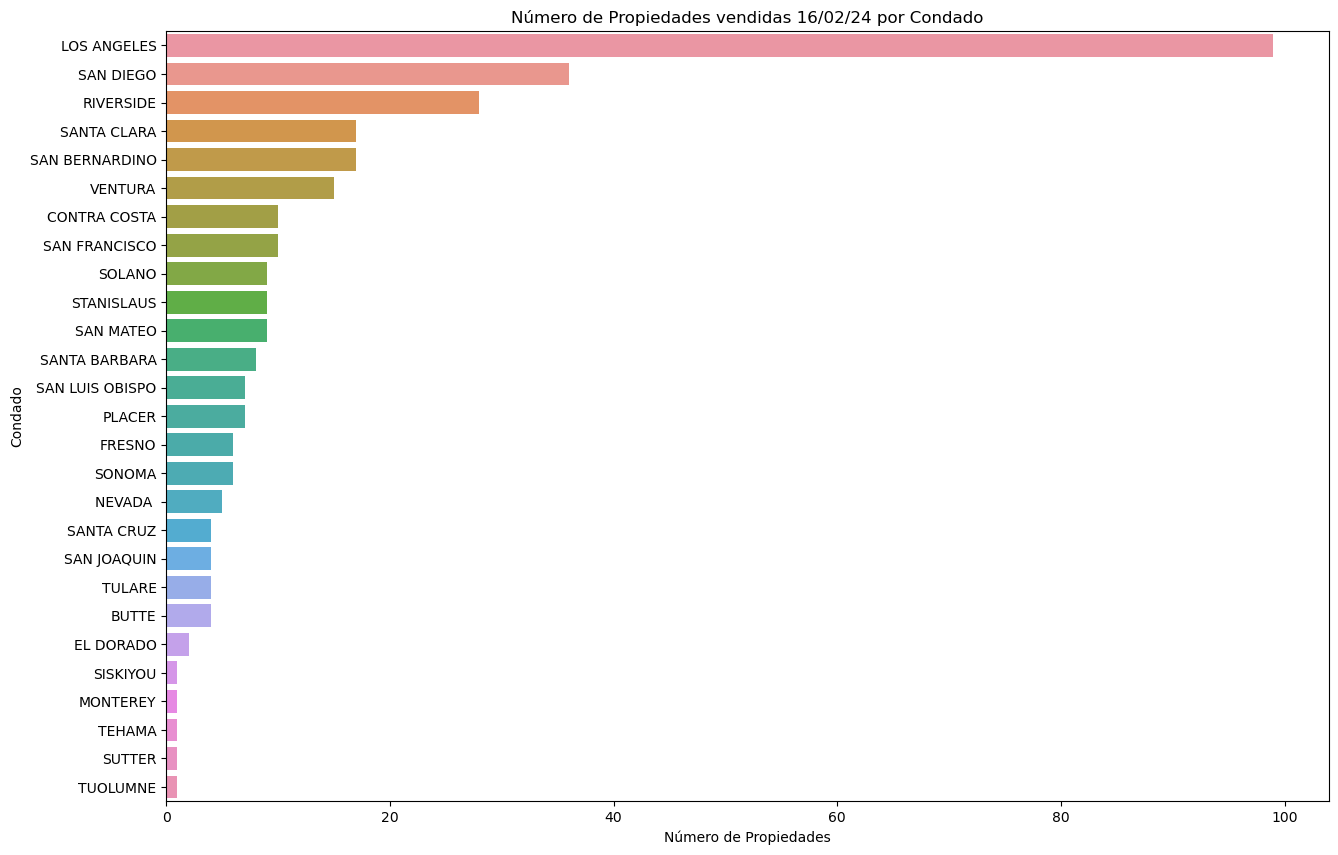

In [18]:
plt.figure(figsize=(15, 10))
sns.countplot(y='COUNTY', data=df_bueno, order = df_bueno['COUNTY'].value_counts().index)
plt.title('Número de Propiedades vendidas 16/02/24 por Condado')
plt.xlabel('Número de Propiedades')
plt.ylabel('Condado')
plt.show()


C:\Users\vsanc\AppData\Local\Temp\ipykernel_16284\3026696954.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  average_price_plot = sns.barplot(x='average_listing_price', y='COUNTY', data=df_bueno, estimator=np.mean, ci=None, order=df_bueno.groupby('COUNTY')['average_listing_price'].mean().sort_values(ascending=False).index)


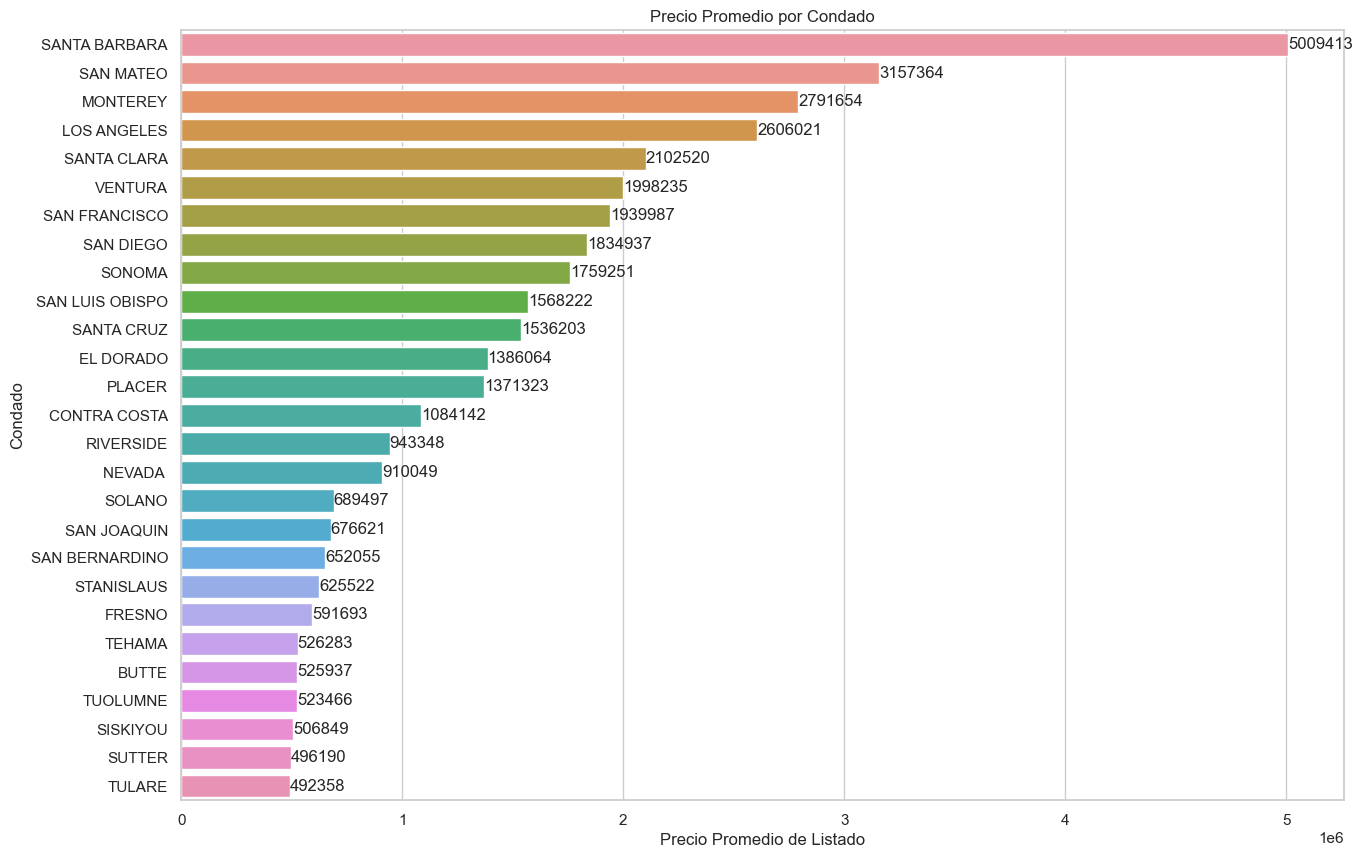

In [19]:
plt.figure(figsize=(15, 10))
sns.set(style="whitegrid")

# Crea el gráfico de barras para el precio promedio por condado
average_price_plot = sns.barplot(x='average_listing_price', y='COUNTY', data=df_bueno, estimator=np.mean, ci=None, order=df_bueno.groupby('COUNTY')['average_listing_price'].mean().sort_values(ascending=False).index)

# Añade el valor promedio en cada barra
for p in average_price_plot.patches:
    width = p.get_width()    # Obtener el ancho de la barra (el valor promedio en este caso)
    average_price_plot.text(width + 3,  # Posición en x donde se colocará el texto
                            p.get_y() + p.get_height() / 2,  # Posición en y
                            f'{int(width)}',  # Texto a mostrar (valor promedio)
                            ha = 'left',   # Alineación horizontal
                            va = 'center')  # Alineación vertical

plt.title('Precio Promedio por Condado')
plt.xlabel('Precio Promedio de Listado')
plt.ylabel('Condado')
plt.show()


Aqui podemos observar que Santa Barbara tiene un menor volumen de venta de propiedades, es la que tiene el promedio de precio más alto, igual ocurre con San Mateo y Monte Rey.

c:\Users\vsanc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


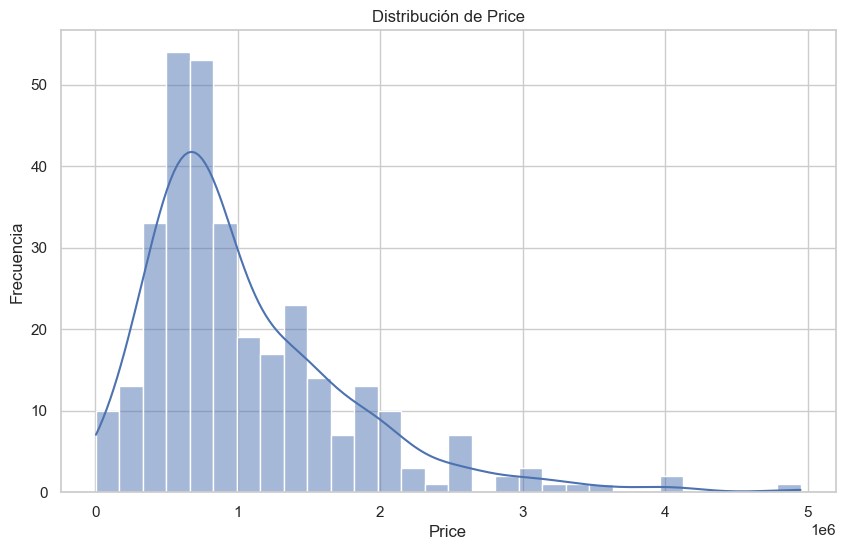

c:\Users\vsanc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


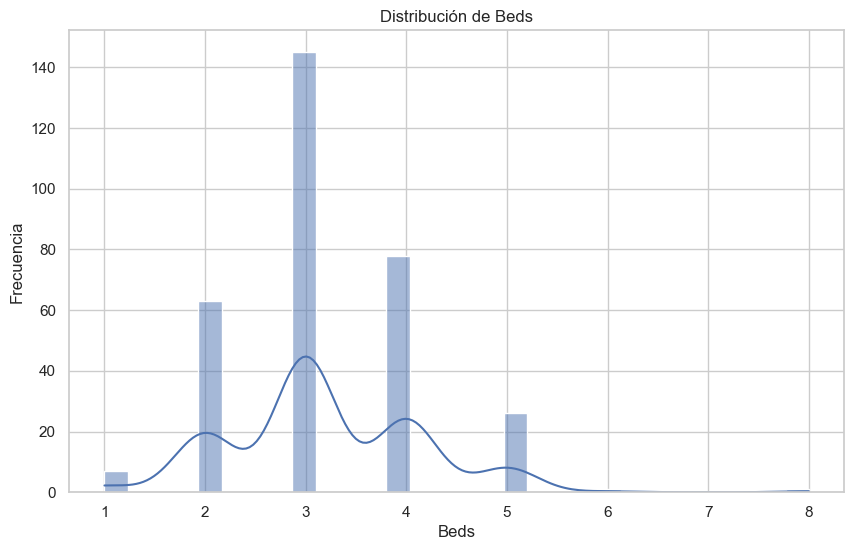

c:\Users\vsanc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


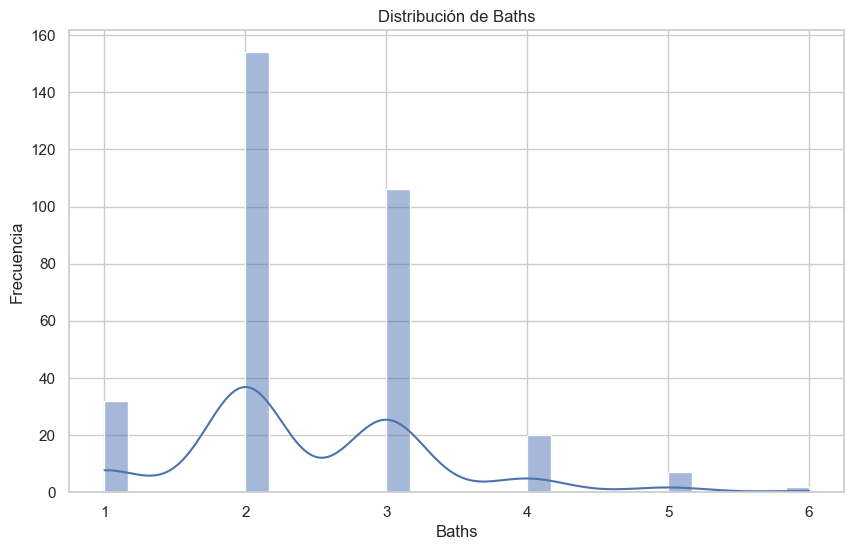

c:\Users\vsanc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


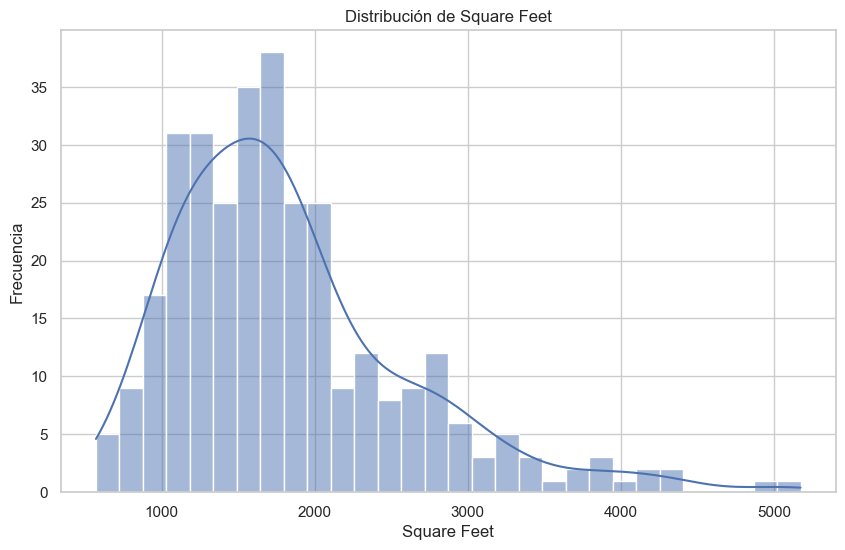

c:\Users\vsanc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


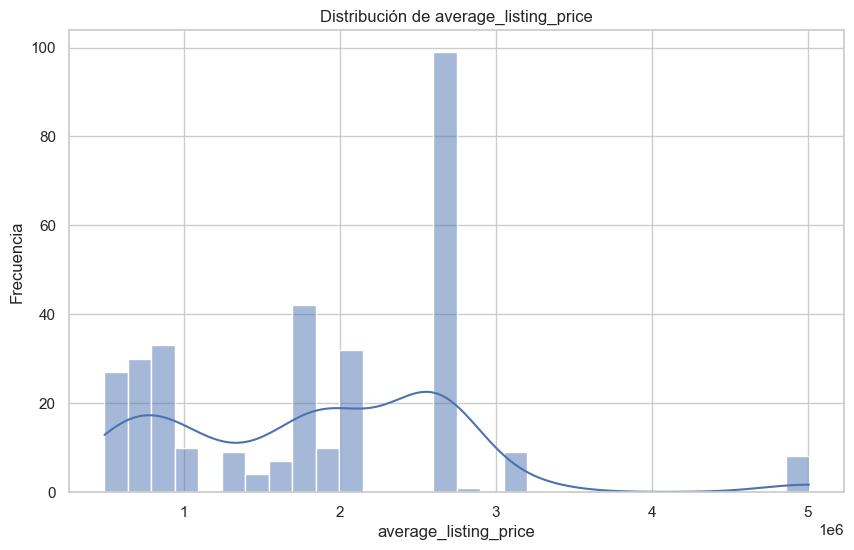

In [20]:
# Lista de columnas numéricas para los cuales quieres generar histogramas
numeric_columns = ['Price', 'Beds', 'Baths', 'Square Feet', 'average_listing_price']

# Genera y muestra un histograma para cada variable numérica
for column in numeric_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_bueno[column], kde=True, bins=30)  # 'kde=True' añade una curva de densidad estimada
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.show()

In [21]:
df_bueno.to_csv('df_BUENO.csv')

## 1: Cargar y Preparar los Datos

In [2]:
df_FINAL = pd.read_csv('df_BUENO.csv')

In [3]:
df_FINAL

,Unnamed: 0,id_image,Price,Beds,Baths,Square Feet,Street,City,COUNTY,average_listing_price
0,0,2200 Sacramento St APT 206,1720000.0,2,2,969.0,2200 Sacramento St APT 206,SAN FRANCISCO,SAN FRANCISCO,1939987.0
1,1,114 10th Ave,1850000.0,3,2,2181.0,114 10th Ave,SAN FRANCISCO,SAN FRANCISCO,1939987.0
2,2,1982 44th Ave,1450000.0,3,2,1150.0,1982 44th Ave,SAN FRANCISCO,SAN FRANCISCO,1939987.0
3,3,2731 41st Ave,1310000.0,2,1,1012.0,2731 41st Ave,SAN FRANCISCO,SAN FRANCISCO,1939987.0
4,4,216 Dorland St,1360000.0,2,2,1132.0,216 Dorland St,SAN FRANCISCO,SAN FRANCISCO,1939987.0
...,...,...,...,...,...,...,...,...,...,...
316,316,2232 Daladier Dr,1680000.0,4,3,2948.0,2232 Daladier Dr,RANCHO PALOS VERDES,LOS ANGELES,2606021.0
317,317,27989 Beechgate Dr,1550000.0,4,3,2390.0,27989 Beechgate Dr,RANCHO PALOS VERDES,LOS ANGELES,2606021.0
318,318,13218 La Jolla Cir UNIT C,675000.0,3,2,1271.0,13218 La Jolla Cir UNIT C,LA MIRADA,LOS ANGELES,2606021.0
319,319,14348 Flomar Dr,745000.0,2,2,1479.0,14348 Flomar Dr,WHITTIER,LOS ANGELES,2606021.0


Eliminar columna Unnamed: 0

In [4]:
df_FINAL.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
df_FINAL

,id_image,Price,Beds,Baths,Square Feet,Street,City,COUNTY,average_listing_price
0,2200 Sacramento St APT 206,1720000.0,2,2,969.0,2200 Sacramento St APT 206,SAN FRANCISCO,SAN FRANCISCO,1939987.0
1,114 10th Ave,1850000.0,3,2,2181.0,114 10th Ave,SAN FRANCISCO,SAN FRANCISCO,1939987.0
2,1982 44th Ave,1450000.0,3,2,1150.0,1982 44th Ave,SAN FRANCISCO,SAN FRANCISCO,1939987.0
3,2731 41st Ave,1310000.0,2,1,1012.0,2731 41st Ave,SAN FRANCISCO,SAN FRANCISCO,1939987.0
4,216 Dorland St,1360000.0,2,2,1132.0,216 Dorland St,SAN FRANCISCO,SAN FRANCISCO,1939987.0
...,...,...,...,...,...,...,...,...,...
316,2232 Daladier Dr,1680000.0,4,3,2948.0,2232 Daladier Dr,RANCHO PALOS VERDES,LOS ANGELES,2606021.0
317,27989 Beechgate Dr,1550000.0,4,3,2390.0,27989 Beechgate Dr,RANCHO PALOS VERDES,LOS ANGELES,2606021.0
318,13218 La Jolla Cir UNIT C,675000.0,3,2,1271.0,13218 La Jolla Cir UNIT C,LA MIRADA,LOS ANGELES,2606021.0
319,14348 Flomar Dr,745000.0,2,2,1479.0,14348 Flomar Dr,WHITTIER,LOS ANGELES,2606021.0


## 2: Preparar la Función para Mostrar Imágenes

In [6]:
def mostrar_imagenes(df_FINAL, carpeta_imagenes, num_imagenes=6):
    # Asegurarse de que el número de imágenes a mostrar no exceda el tamaño del DataFrame
    num_imagenes = min(num_imagenes, len(df_FINAL))
    
    # Seleccionar aleatoriamente 'num_imagenes' filas del DataFrame
    muestras_df = df_FINAL.sample(n=num_imagenes)
    
    plt.figure(figsize=(15, 10))
    for i, fila in enumerate(muestras_df.itertuples(), start=1):
        ruta_imagen = os.path.join(carpeta_imagenes, f"{fila.id_image}.jpg")
        print(f"Intentando abrir: {ruta_imagen}")  # Imprimir la ruta para depuración
        try:
            imagen = Image.open(ruta_imagen)
            plt.subplot(2, 3, i)
            plt.imshow(imagen)
            plt.title(f"Price: {fila.Price}")
            plt.axis('off')
        except FileNotFoundError:
            print(f"No se pudo abrir: {ruta_imagen}")  # Mensaje si la imagen no se encuentra
    plt.show()



##  3: Mostrar Imágenes

Intentando abrir: C:/Users/vsanc/OneDrive/Escritorio/PROYECTO SMART VALUATION/zillow_images\3656 Torrey View Ct.jpg
Intentando abrir: C:/Users/vsanc/OneDrive/Escritorio/PROYECTO SMART VALUATION/zillow_images\620 Foresthill Ave.jpg
Intentando abrir: C:/Users/vsanc/OneDrive/Escritorio/PROYECTO SMART VALUATION/zillow_images\1520 E Harvard St.jpg
Intentando abrir: C:/Users/vsanc/OneDrive/Escritorio/PROYECTO SMART VALUATION/zillow_images\6602 Bobritt Ln.jpg
Intentando abrir: C:/Users/vsanc/OneDrive/Escritorio/PROYECTO SMART VALUATION/zillow_images\1111 Yosemite St.jpg
Intentando abrir: C:/Users/vsanc/OneDrive/Escritorio/PROYECTO SMART VALUATION/zillow_images\3611 Las Palmas Ave.jpg


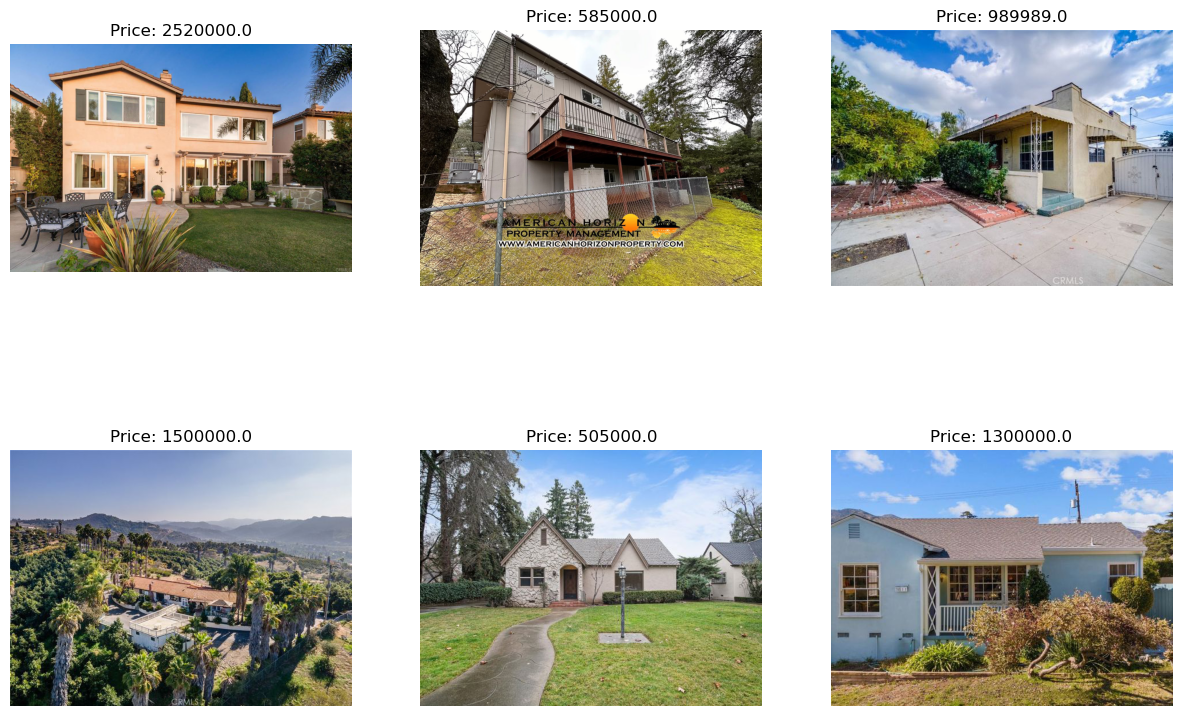

In [7]:
# Especifica la ruta a tu carpeta de imágenes
carpeta_imagenes = 'C:/Users/vsanc/OneDrive/Escritorio/PROYECTO SMART VALUATION/zillow_images'  
# Llama a la función para mostrar imágenes
mostrar_imagenes(df_FINAL, carpeta_imagenes)


In [8]:
# Prueba de normalidad (Shapiro-Wilk) para cada columna numérica
columnas_numericas = ['Price', 'Beds', 'Baths', 'Square Feet', 'average_listing_price']
resultados_normalidad = {columna: stats.shapiro(df_FINAL[columna]) for columna in columnas_numericas}

In [9]:
# Decidir qué escalar aplicar basado en la normalidad y la presencia de outliers
outliers_decision = {}
for columna in columnas_numericas:
    if resultados_normalidad[columna].pvalue > 0.05:
        outliers_decision[columna] = 'StandardScaler'
    else:
        # Calcular IQR para detectar outliers
        Q1 = df_FINAL[columna].quantile(0.25)
        Q3 = df_FINAL[columna].quantile(0.75)
        IQR = Q3 - Q1
        tiene_outliers = ((df_FINAL[columna] < (Q1 - 1.5 * IQR)) | (df_FINAL[columna] > (Q3 + 1.5 * IQR))).any()
        outliers_decision[columna] = 'RobustScaler' if tiene_outliers else 'MinMaxScaler'


In [10]:
# Aplicar escaladores según las decisiones anteriores
for columna, decision in outliers_decision.items():
    if decision == 'RobustScaler':
        scaler = RobustScaler()
        df_FINAL[columna] = scaler.fit_transform(df_FINAL[[columna]])
    elif decision == 'MinMaxScaler':
        scaler = MinMaxScaler()
        df_FINAL[columna] = scaler.fit_transform(df_FINAL[[columna]])

In [11]:
df_FINAL.head()

,id_image,Price,Beds,Baths,Square Feet,Street,City,COUNTY,average_listing_price
0,2200 Sacramento St APT 206,1.097561,-1.0,0.0,-0.871671,2200 Sacramento St APT 206,SAN FRANCISCO,SAN FRANCISCO,0.320481
1,114 10th Ave,1.256098,0.0,0.0,0.595642,114 10th Ave,SAN FRANCISCO,SAN FRANCISCO,0.320481
2,1982 44th Ave,0.768293,0.0,0.0,-0.652542,1982 44th Ave,SAN FRANCISCO,SAN FRANCISCO,0.320481
3,2731 41st Ave,0.597561,-1.0,-1.0,-0.819613,2731 41st Ave,SAN FRANCISCO,SAN FRANCISCO,0.320481
4,216 Dorland St,0.658537,-1.0,0.0,-0.674334,216 Dorland St,SAN FRANCISCO,SAN FRANCISCO,0.320481


## Preparación de características númericas y categóricas

In [12]:
# Preparación de características numéricas y categóricas
caracteristicas_num = ['Beds', 'Baths', 'Square Feet', 'average_listing_price']
caracteristicas_cat = ['Street', 'City', 'COUNTY']  


In [13]:
# Escalado de características numéricas
scaler = StandardScaler()
df_FINAL[caracteristicas_num] = scaler.fit_transform(df_FINAL[caracteristicas_num])

In [14]:
# Codificación de variables categóricas usando pd.get_dummies
df_cat_encoded = pd.get_dummies(df_FINAL[caracteristicas_cat], drop_first=True)

In [15]:
# Concatenación de características numéricas y categóricas
X_estructurado = pd.concat([df_FINAL[caracteristicas_num], df_cat_encoded], axis=1)
y = df_FINAL['Price']

In [16]:
# Calcula el número de características estructuradas resultantes
num_features_estructuradas = X_estructurado.shape[1]

In [17]:
# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_estructurado, y, test_size=0.2, random_state=42)

## Preprocesamiento de imágenes

In [18]:
# Preparación de datos de imágenes
def cargar_y_preprocesar_imagenes(carpeta_imagenes, ids_imagen):
    imagenes = []
    for id_imagen in ids_imagen:
        ruta_imagen = os.path.join(carpeta_imagenes, f"{id_imagen}.jpg")  # Asegúrate de que la extensión sea correcta
        try:
            imagen = Image.open(ruta_imagen)
            imagen = imagen.resize((64, 64))
            if imagen.mode != 'RGB':
                imagen = imagen.convert('RGB')
            imagen = np.array(imagen) / 255.0
            imagenes.append(imagen)
        except FileNotFoundError:
            print(f"No se pudo encontrar o abrir {ruta_imagen}")
    return np.array(imagenes)

In [19]:
carpeta_imagenes = 'C:/Users/vsanc/OneDrive/Escritorio/PROYECTO SMART VALUATION/zillow_images'  
ids_imagen_train = df_FINAL.loc[X_train.index, 'id_image'].values
ids_imagen_test = df_FINAL.loc[X_test.index, 'id_image'].values

In [20]:
# Asegúrate de que solo estás incluyendo los índices que tienen una imagen correspondiente
imagenes_train = cargar_y_preprocesar_imagenes(carpeta_imagenes, ids_imagen_train)
imagenes_test = cargar_y_preprocesar_imagenes(carpeta_imagenes, ids_imagen_test)

In [21]:
# Asegúrate de que el número de imágenes coincida con el número de muestras en X_train y y_train
assert len(imagenes_train) == len(X_train) == len(y_train), "El número de muestras de entrenamiento no coincide."
assert len(imagenes_test) == len(X_test) == len(y_test), "El número de muestras de prueba no coincide."


## Definición del modelo híbrido

Submodelo para datos estructurados

In [22]:
input_estructurados = Input(shape=(X_train.shape[1],), name='datos_estructurados')
x_estructurados = Dense(64, activation='relu')(input_estructurados)
modelo_estructurados = Model(inputs=input_estructurados, outputs=x_estructurados)

Submodelo para imágenes

In [23]:
input_imagenes = Input(shape=(64, 64, 3), name='input_imagenes')
x = Conv2D(32, (3, 3), activation='relu')(input_imagenes)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
modelo_imagenes = Model(inputs=input_imagenes, outputs=x)


Combinación de submodelos

In [24]:
combined = concatenate([modelo_estructurados.output, modelo_imagenes.output])
z = Dense(64, activation='relu')(combined)
z = Dense(1, activation='linear')(z)
modelo_combinado = Model(inputs=[modelo_estructurados.input, modelo_imagenes.input], outputs=z)

## Compilación y entrenamiento del modelo

In [26]:
# Asegúrate de que los datos estructurados están en formato float32
X_train = np.array(X_train).astype('float32')
X_test = np.array(X_test).astype('float32')

In [27]:
# Comprueba que las imágenes ya estén en float32 debido a la división por 255.0, pero si no es así, conviértelas
imagenes_train = imagenes_train.astype('float32')
imagenes_test = imagenes_test.astype('float32')

In [28]:
# Comprueba que las etiquetas 'y' también estén en formato float32
y_train = np.array(y_train).astype('float32')
y_test = np.array(y_test).astype('float32')

In [29]:
# Ahora intenta compilar y entrenar el modelo nuevamente
modelo_combinado.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [30]:
# Utiliza un try-except para capturar posibles errores durante el entrenamiento
try:
    modelo_combinado.fit(
        [X_train, imagenes_train], y_train,
        epochs=10,
        batch_size=32,
        validation_data=([X_test, imagenes_test], y_test)
    )
except Exception as e:
    print(f"Ocurrió un error durante el entrenamiento: {e}")

Epoch 1/10


8/8 [==============================] - 2s 71ms/step - loss: 16.4797 - mae: 2.3670 - val_loss: 0.8077 - val_mae: 0.7328
Epoch 2/10
8/8 [==============================] - 0s 45ms/step - loss: 1.1802 - mae: 0.8474 - val_loss: 1.0968 - val_mae: 0.9045
Epoch 3/10
8/8 [==============================] - 0s 45ms/step - loss: 0.9665 - mae: 0.7230 - val_loss: 1.1420 - val_mae: 0.9375
Epoch 4/10
8/8 [==============================] - 0s 44ms/step - loss: 0.7875 - mae: 0.6519 - val_loss: 0.7419 - val_mae: 0.7190
Epoch 5/10
8/8 [==============================] - 0s 44ms/step - loss: 0.6184 - mae: 0.5781 - val_loss: 0.4635 - val_mae: 0.5190
Epoch 6/10
8/8 [==============================] - 0s 47ms/step - loss: 0.5183 - mae: 0.5409 - val_loss: 0.4247 - val_mae: 0.4420
Epoch 7/10
8/8 [==============================] - 0s 52ms/step - loss: 0.4428 - mae: 0.4813 - val_loss: 0.3854 - val_mae: 0.4131
Epoch 8/10
8/8 [==============================] - 0s 49ms/step - loss: 0.3794 - mae: 0.4543 - 

# Guardamos el modelo en el formato HDF5

In [ ]:
modelo_combinado.save('mi_modelo_hibrido.h5')  

Y así es como podríamos cargarlo más tarde:

In [ ]:
#from tensorflow.keras.models import load_model

#modelo_cargado = load_model('mi_modelo_hibrido.h5')  # Carga el modelo